In [2]:
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt

import iris
import iris.plot as iplt
import iris.quickplot as qplt
import cftime
import datetime

from shapely.geometry import MultiPoint # used for clipping geographic regions

import numpy as np
import pandas as pd
from random import randint

import shape_utils as shape
import atmos_nrt_utils

import os
import requests  # Used to download data
import csv

In [3]:
# Go to repository root directory
if "_changed_dir" not in locals():
    os.chdir("../")
    _changed_dir = True

## Parameters

In [4]:
#Air quality data and time settings
metric       = "daqi" # allowable values -> "no2", "so2", "o3", "daqi"
start_date   = datetime.datetime(2020, 1, 1)
end_date     = datetime.datetime(2020, 1, 9) # max allowable value is -> datetime.datetime(2020, 6, 17) 
raw_data_dir = os.path.join("data", "raw", "metoffice")

#Location of the region shape files
region_shape_file = "2015_PUA_polygons_UK.shx"
region_shape_dir  = os.path.join("data", "annex", "metoffice")

#Controlling csv output
csv_name   = "example_air_quality_file.csv"
output_dir = os.path.join("data", "processed")
output_fmt = "%.4f"

## Obtaining Air Quality Data files
The MET office data can be found [here](https://metdatasa.blob.core.windows.net/covid19-response/index.html). We use the `requests` module to download the desired data files, although if the file is already on the system then it is not downloaded.

The request URL is generated programatically according to the data type, the desired quantity and the reporting hour, allowing the file download to be automated without using the `azcopy` method that was recommended by the MET office dev team.

The data is provided in a .nc file which is a subset of the NetCDF (Common Data Form) file type. We use the MET office `iris` package to interrogate the data.

Utility functions for enabling these operations are contained in the `atmos_nrt_utils.py` file in this directory.

In [6]:
atmos_nrt_utils.metoffice_url_generator('so3', '20200101')

'metoffice_aqum_hourly/so3/aqum_hourly_so3_20200101.nc'

In [7]:
#Construct the urls to download the raw data from the MET Office website
url_prefix = "https://metdatasa.blob.core.windows.net/covid19-response"

date_arr = np.arange(start_date, end_date, datetime.timedelta(days=1)).astype(datetime.datetime)
date_str = [date.strftime("%Y%m%d") for date in date_arr]

urls = [atmos_nrt_utils.metoffice_url_generator(metric, d_str) for d_str in date_str]

raw_data_dir = os.path.join('data', 'raw', 'metoffice')
if not os.path.exists(raw_data_dir):
    os.makedirs(raw_data_dir)

In [8]:
urls

['metoffice_aqum_daily/daqi/aqum_daily_daqi_mean_20200101.nc',
 'metoffice_aqum_daily/daqi/aqum_daily_daqi_mean_20200102.nc',
 'metoffice_aqum_daily/daqi/aqum_daily_daqi_mean_20200103.nc',
 'metoffice_aqum_daily/daqi/aqum_daily_daqi_mean_20200104.nc',
 'metoffice_aqum_daily/daqi/aqum_daily_daqi_mean_20200105.nc',
 'metoffice_aqum_daily/daqi/aqum_daily_daqi_mean_20200106.nc',
 'metoffice_aqum_daily/daqi/aqum_daily_daqi_mean_20200107.nc',
 'metoffice_aqum_daily/daqi/aqum_daily_daqi_mean_20200108.nc']

In [9]:
file_paths = atmos_nrt_utils.get_data_file_paths(urls, url_prefix, raw_data_dir)

## Data Overview
Here we plot a sample of the data for the entirety of the UK to give you an idea of the quantity of data we are dealing with.

The MET Office provides the air quality data on an hourly basis for a 12kmx12km grid for each day from 01 Jan 2020. For more information see this [link](https://metdatasa.blob.core.windows.net/covid19-response/README_data_air_quality.html).

We pass in a list of files to `iris.load` wich returns an `iris.Cube.CubeList` object. 

In [10]:
cube_list  = iris.load(file_paths)

In [11]:
cube_list  = iris.load(file_paths)
cube_slice = cube_list[0]

#Extract the coordinate reference system from one of the cubes. We will use this later.
crs = cube_slice[0].coord_system()

In [12]:
#Display the meta
cube_list

[<iris 'Cube' of daily_air_quality_index / (1) (time: 8; projection_y_coordinate: 704; projection_x_coordinate: 548)>]

In [13]:
#What are the coordinate names?
for coord in cube_slice.coords():
    print(coord.name())
#What is the shape of the cube?
cube_slice.shape

time
projection_y_coordinate
projection_x_coordinate
experiment_number
forecast_day
height
forecast_reference_time


(8, 704, 548)

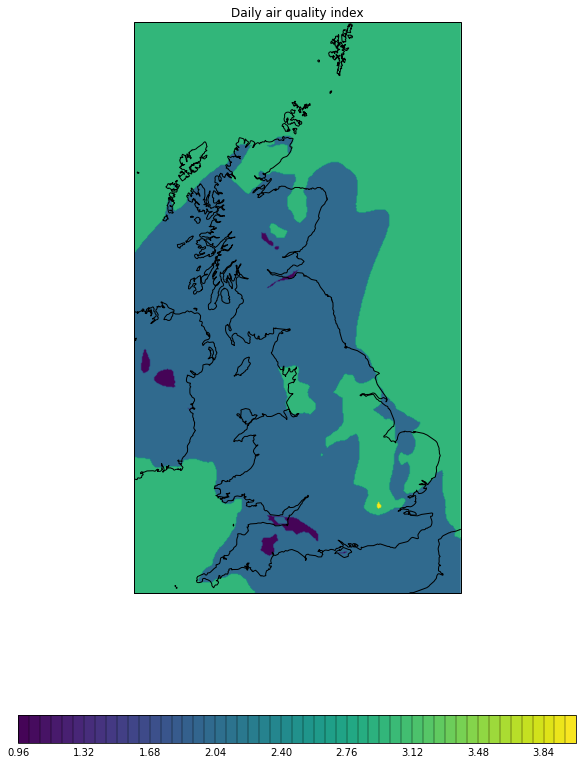

In [14]:
#Give an example of the data
#Use code from example @ https://stackoverflow.com/questions/62346854/how-to-convert-projection-x-and-y-coordinate-in-netcdf-iris-cube-to-lat-lon

crs_latlon = ccrs.OSGB() #UK Ordinance Survey projection gives nice plots for UK data
n_levels   = 50

#Each cube has 3D data (time, projection_x_coordinate, projection_y_coordinate), contour can only plot spatial data so plot slice in time
sample_cube = next(cube_slice.slices(['projection_x_coordinate', 'projection_y_coordinate']))

proj_x = cube_slice.coord("projection_x_coordinate").points
proj_y = cube_slice.coord("projection_y_coordinate").points
cs_nat_cart = cube_slice.coord_system().as_cartopy_projection()

fig = plt.figure(figsize=(10, 15))
ax = fig.add_subplot(111, projection=crs_latlon)
ax.coastlines("10m")
qplt.contourf(sample_cube, n_levels)


Whilst this plot may look pretty we cannot derive any meaningful insights from the data in this current form. We need to group the data by geographic region and then calculate the average air quality for each region is we are to have any hope of correlating this data set with other signals.

## Geographic Regions
We use the Principal Urban Areas (PUA) to group the atmospheric data by geographic regions. Note, we would have preferred to use the Covid-19 Reporting Regions but we had some trouble getting this to work.

Each region is defined by a [shape file](https://pypi.org/project/pyshp/) with the following attributes:
* PUACode: A unique code for the region
* PUAName: The name of the region, e.g. Hartlepool
* Easting: The easting of the bottom left corner of the PUA
* Northings: The northing of the bottom left corner of the PUA
* Area_ha: The area of the region (in hectares)

The shapefile also contains the coordinates of the region, which we can use to group the air quality data.

In [15]:
regions_reader = shpreader.Reader(os.path.join(region_shape_dir, region_shape_file))

In [16]:
#Give an overview of the data in a region
rcd = next(regions_reader.records())
print("The are {} regions with the following attributes:\n{}".format(len([record for record in regions_reader.records()]), list(rcd.attributes.keys())))

The are 63 regions with the following attributes:
['PUACode', 'PUAName', 'Eastings', 'Northings', 'Area_ha']


In [17]:
region = next(regions_reader.records())

PUA Name: Aberdeen
PUA Code: AB
PUA Area: 20561.027969


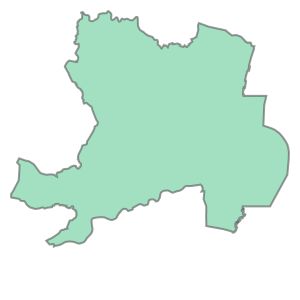

In [18]:
print('PUA Name: {}\nPUA Code: {}\nPUA Area: {}'.format(region.attributes['PUAName'], region.attributes['PUACode'], region.attributes['Area_ha']))
next(regions_reader.geometries())

In [19]:
#Plot all of the regions so we can see what we are working with
region_ids = [record.attributes['PUAName'] for record in regions_reader.records()]
print(region_ids)

['Aberdeen', 'Blackburn', 'Bradford', 'Bournemouth', 'Birmingham', 'Brighton', 'Bristol', 'Burnley', 'Barnsley', 'Cambridge', 'Cardiff', 'Coventry', 'Crawley', 'Dundee', 'Derby', 'Doncaster', 'Edinburgh', 'Exeter', 'Aldershot', 'Blackpool', 'Glasgow', 'Gloucester', 'Huddersfield', 'Hull', 'Ipswich', 'Leicester', 'London', 'Leeds', 'Luton', 'Liverpool', 'Manchester', 'Chatham', 'Mansfield', 'Milton Keynes', 'Newcastle', 'Nottingham', 'Northampton', 'Newport', 'Norwich', 'Oxford', 'Peterborough', 'Plymouth', 'Portsmouth', 'Preston', 'Reading', 'Swansea', 'Sheffield', 'Slough', 'Swindon', 'Southampton', 'Sunderland', 'Southend', 'Stoke', 'Basildon', 'Telford', 'Middlesbrough', 'Warrington', 'Wakefield', 'Birkenhead', 'Wigan', 'Worthing', 'York', 'Belfast']


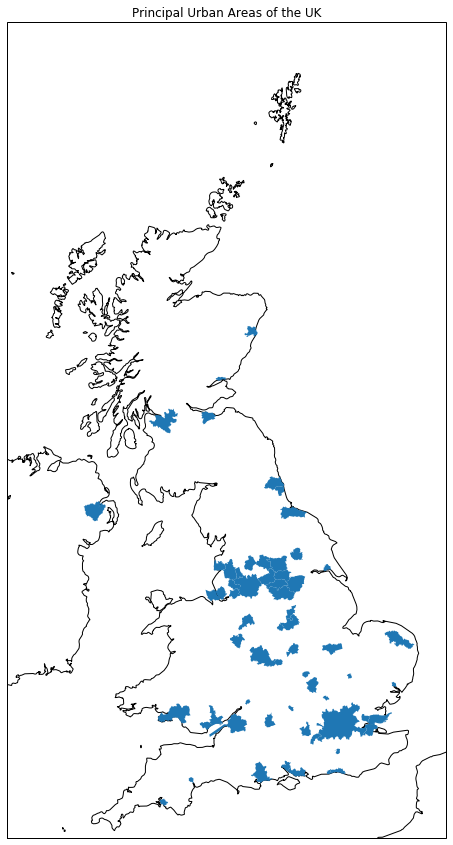

In [20]:
plt.figure(figsize=(10, 15))
ax = plt.axes(projection=ccrs.OSGB())
ax.coastlines('10m')

ax.add_geometries(regions_reader.geometries(), ccrs.OSGB())
ax.set_title("Principal Urban Areas of the UK")
plt.show()

## Group by Geograpic Region
Next we use the geographic regions to group the atmospheric data.

Leeds


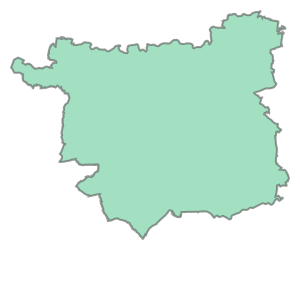

In [21]:
#Get a random geometry to check it's all working as expected
region_name   = atmos_nrt_utils.rand_id(region_ids)
region_record = atmos_nrt_utils.get_region_record(region_name, regions_reader)
print(region_name)
region_record.geometry

We use the MET Office `shape_utils` library to define geographic regions (shapes) and then split the cube into subsets. We use the hybrid approach proposed in the `datasets/share/air_quality_example_code/cut_code.ipynb` notebook on the MET Office Infomatics Lab portal as this approach offers the quickest solution to the region clipping.

In [22]:
cut_cubes = atmos_nrt_utils.cut_cubes_to_shape(cube_list, region_record)
cut_cubes

[<iris 'Cube' of daily_air_quality_index / (1) (time: 8; projection_y_coordinate: 15; projection_x_coordinate: 17)>]

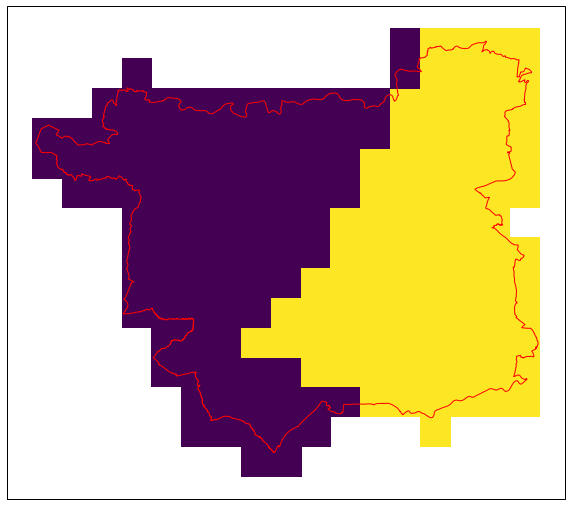

In [23]:
plt.figure(figsize=(10, 15))
ax = plt.axes(projection=ccrs.OSGB())
ax.coastlines('10m')
              
iplt.pcolormesh(cut_cubes[0][0])
ax.add_geometries([region_record.geometry], ccrs.OSGB(),
                  edgecolor='r', facecolor='none')
plt.show()

## Extract Average for Each Geographic Region
We compute the average for each geographic region as this will allow us to plot time series data for each region during the lockdown. It is important to note that this will ignore localised effects when the region comprises of many 12kmx12km grids.

In [24]:
#We need to use the average over the region in order to generate time series data for each pollutant and each region
mean_cubes = [cube.collapsed(['projection_y_coordinate','projection_x_coordinate'],iris.analysis.MEAN) for cube in cut_cubes]

#Remove the scalar coordinate 'forecast_reference_time' to allow cubes to concatenated
for cube in mean_cubes:
    cube.remove_coord('forecast_reference_time')

In [25]:
concat_mean_cubes = iris.cube.CubeList(mean_cubes).concatenate_cube()

In [26]:
concat_mean_cubes

Daily Air Quality Index (1),time
Shape,8
Dimension coordinates,
time,x
Scalar coordinates,
experiment_number,0
forecast_day,1
height,1.65 m
projection_x_coordinate,"430000.0 m, bound=(413000.0, 447000.0) m"
projection_y_coordinate,"436000.0 m, bound=(421000.0, 451000.0) m"
Attributes,


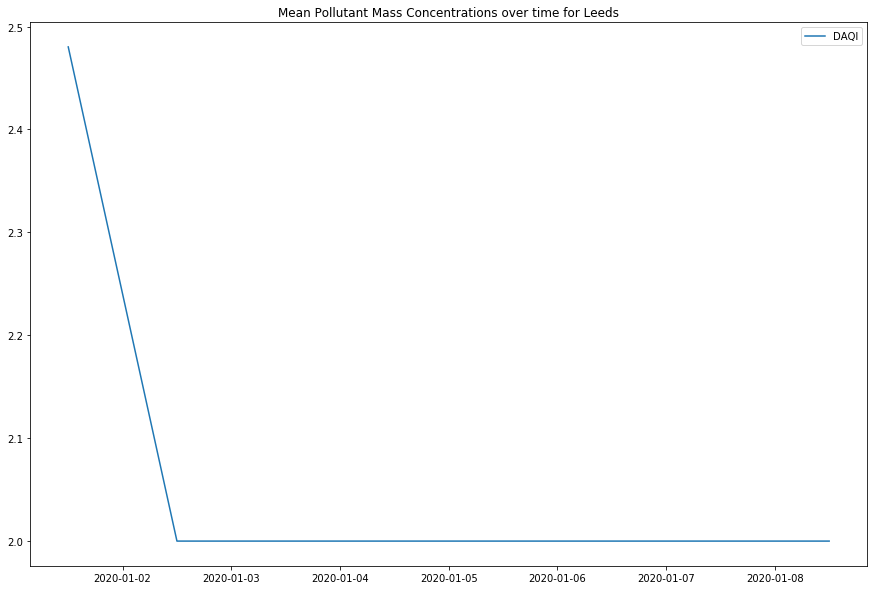

In [27]:
plt.figure(figsize=(15, 10))

#for cube in mean_cubes:
#    iplt.plot(cube, label=cube.attributes['short_name'])

iplt.plot(concat_mean_cubes, label = concat_mean_cubes[0].attributes['short_name'])
 
plt.legend()
plt.title(f'Mean Pollutant Mass Concentrations over time for {region_name}')

plt.show()

Finally, we return the data in a Pandas DataFrame to allow easy manipulation of the processed data.

In [28]:
df = atmos_nrt_utils.convert_cube_to_dateframe(concat_mean_cubes, region_name)
df.head(10)

,Leeds
01/01/2020 12:00:00,2.480226
02/01/2020 12:00:00,2.000000
03/01/2020 12:00:00,2.000000
04/01/2020 12:00:00,2.000000
05/01/2020 12:00:00,2.000000
06/01/2020 12:00:00,2.000000
07/01/2020 12:00:00,2.000000
08/01/2020 12:00:00,2.000000


In [29]:
#Setup csv header and meta - this file will be written to by successive DataFrames using the 'append' option
csv_path = os.path.join(output_dir, csv_name)
with open(csv_path, 'w',  newline='') as csvfile:
    emission_writer = csv.writer(csvfile, delimiter=",")
    emission_writer.writerow(['quantity', 'mean_' + cube_list[0].name()])
    emission_writer.writerow(['units'   , cube_list[0].units])
    emission_writer.writerow(list(df.columns))

In [30]:
df.to_csv(csv_path, mode='a', header=False, index_label='date', float_format=output_fmt)

In [31]:
#Check we can read it in again
df_check = pd.read_csv(csv_path, skiprows = 2)
df_check.head(10)

,Leeds
01/01/2020 12:00:00,2.4802
02/01/2020 12:00:00,2.0000
03/01/2020 12:00:00,2.0000
04/01/2020 12:00:00,2.0000
05/01/2020 12:00:00,2.0000
06/01/2020 12:00:00,2.0000
07/01/2020 12:00:00,2.0000
08/01/2020 12:00:00,2.0000


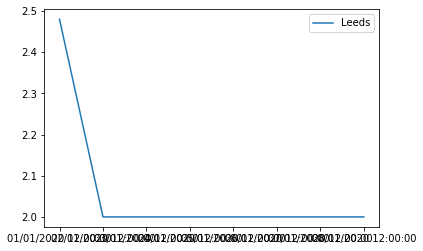

In [32]:
df_check.plot()